/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_11494/4067666123.py:9: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data/202409-citibike-tripdata/202409-citibike-tripdata_1.csv')


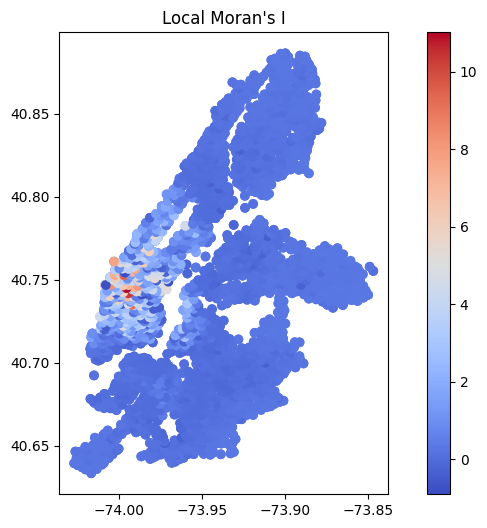

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pysal.lib import weights
from pysal.explore import esda
import matplotlib.pyplot as plt

# Read data
data = pd.read_csv('./data/202409-citibike-tripdata/202409-citibike-tripdata_1.csv')

# Aggregate data to calculate the number of rides for each station
station_counts = data.groupby('start_station_id').size().reset_index(name='ride_count')

# Get the geographical location of each station
station_locations = data.drop_duplicates('start_station_id')[['start_station_id', 'start_lat', 'start_lng']]

# Merge data
station_data = pd.merge(station_counts, station_locations, on='start_station_id')

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(station_data, geometry=gpd.points_from_xy(station_data.start_lng, station_data.start_lat))

# Create weight matrix
w = weights.DistanceBand.from_dataframe(gdf, threshold=0.01, silence_warnings=True)

# Calculate Local Moran's I
local_moran = esda.Moran_Local(gdf['ride_count'], w)

# Add results to GeoDataFrame
gdf['local_moran'] = local_moran.Is
gdf['p_value'] = local_moran.p_sim

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf.plot(column='local_moran', cmap='coolwarm', legend=True, ax=ax)
plt.title("Local Moran's I")
plt.show()

In [4]:
import folium

# Add results to GeoDataFrame
gdf['local_moran'] = local_moran.Is
gdf['p_value'] = local_moran.p_sim

# Add significance level
gdf['significant'] = gdf['p_value'] < 0.05

# Classify
gdf['category'] = 'Not Significant'
gdf.loc[(gdf['local_moran'] > 0) & (gdf['significant']), 'category'] = 'HH'
gdf.loc[(gdf['local_moran'] < 0) & (gdf['significant']), 'category'] = 'LL'
gdf.loc[(gdf['local_moran'] > 0) & (~gdf['significant']), 'category'] = 'HL'
gdf.loc[(gdf['local_moran'] < 0) & (~gdf['significant']), 'category'] = 'LH'

# Define color mapping
color_map = {
    'HH': 'red',
    'LL': 'blue',
    'HL': 'yellow',
    'LH': 'green',
    'Not Significant': 'gray'
}

# Create map object
m = folium.Map(location=[gdf['start_lat'].mean(), gdf['start_lng'].mean()], zoom_start=13)

# Add station markers to the map
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=5,
        popup=f"{row['start_station_id']}: {row['category']}",
        color=color_map[row['category']],
        fill=True,
        fill_color=color_map[row['category']]
    ).add_to(m)

# Save map to file
m.save('./map/stations_local_moran_map.html')
